# Introduction

Notebook para executar grid-search para encontrar melhores parâmetros para RL com NAS-v3 em variados datasets de NATS-Bench-201.

# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

In [3]:
from IPython.display import clear_output

import pandas as pd
import numpy as np

In [4]:
import sys
if '../..' not in sys.path:
    sys.path.insert(0, '../..')
    
from validation_src.val_nas_executor import NASExecutor 

from src.base.experiment.training.optimizers import Optimizer

In [5]:
## restrict memory growth -------------------
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try:
    gpu_0 = physical_devices[0]
    tf.config.experimental.set_memory_growth(gpu_0, True) 
    #tf.config.experimental.set_virtual_device_configuration(gpu_0, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6500)])
    print(' ==> Restrict GPU memory growth: True')
except: 
    raise Exception("Invalid device or cannot modify virtual devices once initialized.")
## restrict memory growth ------------------- 

 ==> Restrict GPU memory growth: True


# Run Grid Search

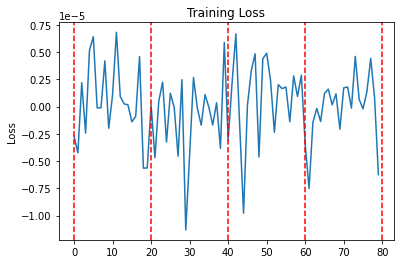

In [6]:
ss_indicators = ['tss'] #'sss'
algos_list = ['rl']  # ,'random','evolution'
datasets_list = ['ImageNet16-120','cifar10','cifar100']
mth_list = [100]
use_neptune = True

optimizers = [Optimizer.ADAMAX, Optimizer.ADAM, Optimizer.SGD]
loss_alphas = [0.3, 0.6, 0.9]
use_predictor_list = [True, False]


def get_kwargs(ss_indic, optim, loss_alp, use_pred):
    kwargs = {
            'controller_params': {
            'controller_max_proposed_arch_len': 5 if ss_indic == 'sss' else 6,   # == sss = 5 / tss = 6
            'controller_classes': 8 if ss_indic == 'sss' else 5,    # == n_candidates ==> sss = 8 / n_operations ==> tss = 5
            'controller_lstm_dim': 100,
            'controller_optimizer': optim,
            'controller_learning_rate': 0.01,
            'controller_decay': 0.1,
            'controller_momentum': 0.0,
            'controller_use_predictor': use_pred,
            'controller_loss_alpha': loss_alp,  # 0.9, 0.6, 0.3
            'controller_training_epochs': 20,
            'controller_batch_size': 256
        }
    }
    return kwargs


for ss in ss_indicators:
    for a in algos_list:
        for d in datasets_list:
            for mth in mth_list:
                for o in optimizers:
                    for l in loss_alphas:
                        for up in use_predictor_list:
                            executor = NASExecutor(a, d, mth, ss, use_neptune, get_kwargs(ss, o, l, up))
                            sorted_results = executor.test_nas_algo(f'./results/{ss}/{a}_{str(mth)}h_{d}.csv')
                            clear_output()               

# Download Data from Neptune

In [17]:
import neptune

NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NDc0ZmNhNi0wODFlLTRhYTktYjgwZS01MWJkMDMxNWJhNTAifQ=="
NEPTUNE_PROJECT="guilhermemg/nas-v3" 

project = neptune.init_project(
    project=NEPTUNE_PROJECT,  
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

cols = ['best_arch/algorithm', 
        'best_arch/dataset', 
        'best_arch/dna', 
        'best_arch/id', 
        'best_arch/train_accuracy', 
        'best_arch/val_acc',
        'best_arch/test_acc',
        'controller_params/controller_optimizer',
        'controller_params/controller_use_predictor',
        'controller_params/controller_loss_alpha']


def get_best_arch(orig_df, dataset):
    df = orig_df[orig_df['best_arch/dataset'] == dataset]
    df = df.sort_values(by='best_arch/val_acc', ascending=False, ignore_index=True)
    df = df.drop(columns=['best_arch/algorithm','best_arch/dataset'])
    df = df.rename(columns={'controller_params/controller_loss_alpha':'loss_alpha', 
                            'controller_params/controller_optimizer':'optimizer',
                            'controller_params/controller_use_predictor': 'use_predictor'})
    df = df[df['best_arch/val_acc'] == np.max(df['best_arch/val_acc'])].sort_values(by='best_arch/id', ignore_index=True)
    display(df.head(1))

https://app.neptune.ai/guilhermemg/nas-v3/


# Grid Search Results Analysis

## SSS

In [24]:
sss_runs_df = project.fetch_runs_table(tag=['grid_search','sss'], columns=cols).to_pandas()
sss_runs_df.shape
sss_runs_df.to_csv('./neptune_data/sss_runs.csv', index=False)

In [25]:
sss_runs_df.head()

,sys/id,best_arch/algorithm,best_arch/dataset,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,controller_params/controller_loss_alpha,controller_params/controller_optimizer,controller_params/controller_use_predictor
0,NAS-259,RL_DNAGenerator(),cifar100,"DNA([3, 6, 7, 6, 7])",2493,69.50,94.226,60.84,0.9,Optimizer.SGD,False
1,NAS-258,RL_DNAGenerator(),cifar100,"DNA([7, 7, 7, 7, 7])",3059,70.72,96.982,61.06,0.9,Optimizer.SGD,True
2,NAS-257,RL_DNAGenerator(),cifar100,"DNA([6, 5, 4, 5, 5])",896,67.90,89.768,58.68,0.6,Optimizer.SGD,False
3,NAS-256,RL_DNAGenerator(),cifar100,"DNA([6, 5, 6, 6, 6])",2671,70.08,93.568,59.26,0.6,Optimizer.SGD,True
4,NAS-255,RL_DNAGenerator(),cifar100,"DNA([7, 7, 7, 7, 7])",105,70.72,96.982,61.06,0.3,Optimizer.SGD,False


In [26]:
get_best_arch(sss_runs_df, 'cifar10')
get_best_arch(sss_runs_df, 'cifar100')
get_best_arch(sss_runs_df, 'ImageNet16-120')

,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-237,"DNA([7, 7, 7, 6, 6])",354,93.18,99.91,85.02,0.3,Optimizer.SGD,False


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-255,"DNA([7, 7, 7, 7, 7])",105,70.72,96.982,61.06,0.3,Optimizer.SGD,False


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-206,"DNA([5, 7, 7, 7, 7])",54,45.433333,56.453527,39.333333,0.3,Optimizer.ADAMAX,True


## TSS - Search Space

In [27]:
tss_runs_df = project.fetch_runs_table(tag=['grid_search','tss'], columns=cols).to_pandas()
tss_runs_df.to_csv('neptune_data/tss_runs.csv', index=False)
tss_runs_df.shape

(54, 11)

In [28]:
tss_runs_df.head()

,sys/id,best_arch/algorithm,best_arch/dataset,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,controller_params/controller_loss_alpha,controller_params/controller_optimizer,controller_params/controller_use_predictor
0,NAS-314,RL_DNAGenerator(),cifar100,"DNA([3, 3, 4, 1, 3, 3])",584,73.00,99.900,60.46,0.9,Optimizer.SGD,False
1,NAS-313,RL_DNAGenerator(),cifar100,"DNA([0, 3, 1, 1, 4, 3])",2829,70.92,99.112,58.96,0.9,Optimizer.SGD,True
2,NAS-312,RL_DNAGenerator(),cifar100,"DNA([3, 1, 1, 1, 3, 3])",629,71.28,99.606,59.50,0.6,Optimizer.SGD,False
3,NAS-311,RL_DNAGenerator(),cifar100,"DNA([3, 3, 4, 1, 3, 3])",738,73.00,99.900,60.46,0.6,Optimizer.SGD,True
4,NAS-310,RL_DNAGenerator(),cifar100,"DNA([0, 3, 4, 1, 4, 2])",1017,70.60,95.756,57.14,0.3,Optimizer.SGD,False


In [29]:
get_best_arch(tss_runs_df, 'cifar10')
get_best_arch(tss_runs_df, 'cifar100')
get_best_arch(tss_runs_df, 'ImageNet16-120')

,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-293,"DNA([3, 2, 3, 1, 3, 3])",127,94.22,99.982,84.968,0.6,Optimizer.SGD,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-303,"DNA([3, 3, 2, 1, 2, 3])",2204,72.48,99.832,61.32,0.3,Optimizer.ADAM,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-269,"DNA([3, 3, 3, 1, 3, 3])",20,45.966667,73.185234,37.633333,0.6,Optimizer.ADAM,True


# Defining Best RL Algorithm Setup

loss_alpha: 
 * **0.3: 4/6**
 * 0.6: 2/6
 
optimizer:
 * ADAM: 2/6
 * **SGD: 3/6**
 * ADAMAX: 1/6
 
use_predictor:
 * **true: 4/6**
 * false: 2/6

# Reexecute Experiments with Best Setup Found

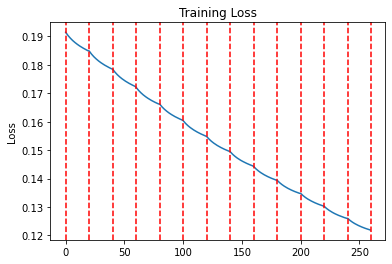

In [31]:
ss_indicators = ['tss','sss']
algos_list = ['rl']  # ,'random','evolution'
datasets_list = ['ImageNet16-120','cifar10','cifar100']
mth_list = [100]
use_neptune = True

optimizers = [Optimizer.SGD]
loss_alphas = [0.3]
use_predictor_list = [True]


def get_kwargs(ss_indic, optim, loss_alp, use_pred):
    kwargs = {
            'controller_params': {
            'controller_max_proposed_arch_len': 5 if ss_indic == 'sss' else 6,   # == sss = 5 / tss = 6
            'controller_classes': 8 if ss_indic == 'sss' else 5,    # == n_candidates ==> sss = 8 / n_operations ==> tss = 5
            'controller_lstm_dim': 100,
            'controller_optimizer': optim,
            'controller_learning_rate': 0.01,
            'controller_decay': 0.1,
            'controller_momentum': 0.0,
            'controller_use_predictor': use_pred,
            'controller_loss_alpha': loss_alp,  # 0.9, 0.6, 0.3
            'controller_training_epochs': 20,
            'controller_batch_size': 256
        }
    }
    return kwargs


for ss in ss_indicators:
    for a in algos_list:
        for d in datasets_list:
            for mth in mth_list:
                for o in optimizers:
                    for l in loss_alphas:
                        for up in use_predictor_list:
                            executor = NASExecutor(a, d, mth, ss, use_neptune, get_kwargs(ss, o, l, up))
                            sorted_results = executor.test_nas_algo(f'./results/best_rl_setup/{ss}/{a}_{str(mth)}h_{d}.csv')
                            clear_output()               

# Calculate Drop on Accuracy

## Download data from Neptune

In [6]:
import neptune

NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NDc0ZmNhNi0wODFlLTRhYTktYjgwZS01MWJkMDMxNWJhNTAifQ=="
NEPTUNE_PROJECT="guilhermemg/nas-v3" 

project = neptune.init_project(
    project=NEPTUNE_PROJECT,  
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

cols = ['best_arch/algorithm', 
        'best_arch/dataset', 
        'best_arch/dna', 
        'best_arch/id', 
        'best_arch/train_accuracy', 
        'best_arch/val_acc',
        'best_arch/test_acc',
        'controller_params/controller_optimizer',
        'controller_params/controller_use_predictor',
        'controller_params/controller_loss_alpha']


def get_best_arch(orig_df, dataset):
    df = orig_df[orig_df['best_arch/dataset'] == dataset]
    df = df.sort_values(by='best_arch/val_acc', ascending=False, ignore_index=True)
    df = df.drop(columns=['best_arch/algorithm','best_arch/dataset'])
    df = df.rename(columns={'controller_params/controller_loss_alpha':'loss_alpha', 
                            'controller_params/controller_optimizer':'optimizer',
                            'controller_params/controller_use_predictor': 'use_predictor'})
    df = df[df['best_arch/val_acc'] == np.max(df['best_arch/val_acc'])].sort_values(by='best_arch/id', ignore_index=True)
    display(df.head(1))

https://app.neptune.ai/guilhermemg/nas-v3/


In [31]:
best_setup_tss_runs_df = project.fetch_runs_table(tag=['rl_best_setup','tss'], columns=cols).to_pandas()
best_setup_tss_runs_df.to_csv('neptune_data/rl_best_setup/tss_runs.csv', index=False)
best_setup_tss_runs_df.shape

(3, 11)

In [18]:
best_setup_sss_runs_df = project.fetch_runs_table(tag=['rl_best_setup','sss'], columns=cols).to_pandas()
best_setup_sss_runs_df.to_csv('neptune_data/rl_best_setup/sss_runs.csv', index=False)
best_setup_sss_runs_df.shape

(3, 11)

## Process Data

### SSS

In [19]:
get_best_arch(best_setup_sss_runs_df, 'cifar10')
get_best_arch(best_setup_sss_runs_df, 'cifar100')
get_best_arch(best_setup_sss_runs_df, 'ImageNet16-120')

,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-319,"DNA([1, 3, 3, 7, 7])",638,91.85,99.434,82.804,0.3,Optimizer.SGD,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-320,"DNA([5, 7, 5, 5, 5])",1494,69.68,91.658,58.64,0.3,Optimizer.SGD,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-318,"DNA([6, 6, 6, 6, 6])",108,45.666667,54.576796,38.133333,0.3,Optimizer.SGD,True


### TSS

In [32]:
get_best_arch(best_setup_tss_runs_df, 'cifar10')
get_best_arch(best_setup_tss_runs_df, 'cifar100')
get_best_arch(best_setup_tss_runs_df, 'ImageNet16-120')

,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-316,"DNA([3, 4, 4, 1, 3, 0])",5712,93.7,99.974,83.508,0.3,Optimizer.SGD,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-317,"DNA([3, 0, 0, 1, 1, 1])",182,67.46,91.032,54.76,0.3,Optimizer.SGD,True


,sys/id,best_arch/dna,best_arch/id,best_arch/test_acc,best_arch/train_accuracy,best_arch/val_acc,loss_alpha,optimizer,use_predictor
0,NAS-315,"DNA([4, 2, 4, 1, 3, 3])",624,41.466667,49.336849,27.9,0.3,Optimizer.SGD,True


## Accuracy Drop Summary

**SSS**:

* Cifar-10
  * Before: 85.02% val_acc / ID = 354
  * After:  82.80% val_acc / ID = 638

* Cifar-100
  
  * Before: 61.06% val_acc / ID = 105 
  * After:  58.64% val_acc / ID = 1494

* ImageNet16-120
  
  - Before: 39.33% val_acc / ID = 54
  - After:  38.13% val_acc / ID = 108
  
  
**TSS**:

* Cifar-10
  
  - Before: 84.96% val_acc / ID = 127
  - After:  83.50% val_acc / ID = 5712 

* Cifar-100
  
  - Before: 61.32% val_acc / ID = 2204
  - After:  58.64% val_acc / ID = 1494

* ImageNet16-120
  
  - Before: 37.63% val_acc / ID = 20
  - After:  27.90% val_acc / ID = 624